In [1]:
import sys
sys.path.append("D:\Edward\Smita_Lab_Work\ImmunoPred\immunopred")

In [2]:
import os
import platform
import argparse
import torch
import wandb
import numpy as np
import configparser
from dgl.dataloading import GraphDataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from dgl.nn import EGNNConv
from models.layers import SelfAttention, MultiHeadAttention
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

In [3]:
from data import ImmunoPredDataset, collate, SplitDataset
from models.mapping import model_map
from procedures import inference
from utils import seed_everything

In [4]:
seed = 2
input_dim = 283 * 21
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
config = configparser.ConfigParser()
config.sequence_pad_count = 0
config.structure_pad_count = 0
config.feature_size = 23
config.coord_size = 3
graph_directory = "D:\Edward\Smita_Lab_Work\IEDB\PyGs"
property_path = "D:\Edward\Smita_Lab_Work\complete_score_Mprops_1_2_smoothed_sasa_v2.txt"
hla_path = "D:\Edward\Smita_Lab_Work\ImmunoPred\data\HLA_27_seqs_csv.csv"

In [5]:
seed_everything(2)
generator = torch.Generator().manual_seed(2)

In [6]:
dataset = ImmunoPredDataset(config, graph_directory = graph_directory, property_path = property_path, hla_path = hla_path)
_, _, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], generator)

Loading graphs: 100%|██████████████████████████████████████████████████████████| 24607/24607 [00:18<00:00, 1346.67it/s]


Loaded 24607 graphs.
new sequence table size: 23339, removed 1200
new graph list size: 23339, removed 0
Counter({0: 18583, 1: 4756})
dupes 0 0
Preprocess Complete


In [7]:
test_split_dataset = SplitDataset(test_dataset, "test", binary=True, full=True, comparative=False, return_amino_acid=False)
test_loader = GraphDataLoader(test_split_dataset, batch_size=1, collate_fn=collate, shuffle=False)

In [8]:
class HybridModelv2(nn.Module):
    def __init__(self,
                 vae_input_dim,
                 device,
                 gcn_layers: int = 5,
                 vae_hidden_dim: int = 512,
                 vae_latent_dim: int = 32,
                 gat_hidden_channels: int = 64,
                 self_attention_heads: int = 1,
                 property_embedding_dim: int = 8,
                 combined_attention_heads: int = 8,
                 *args, **kwargs):
        super().__init__()

        self.device = device
        self.vae_hidden_dim = vae_hidden_dim
        self.vae_latent_dim = vae_latent_dim
        self.vae_input_dim = vae_input_dim
        self.gat_hidden_channels = gat_hidden_channels
        self.property_embedding_dim = property_embedding_dim

        self.GCN_layers = nn.ModuleList([EGNNConv(20, gat_hidden_channels, gat_hidden_channels, 1)])
        for _ in range(gcn_layers):
            self.GCN_layers.append(EGNNConv(gat_hidden_channels, gat_hidden_channels, gat_hidden_channels, 1))

        # GAT components
        self.self_attention = MultiHeadAttention(gat_hidden_channels, self_attention_heads)

        # VAE components
        self.vae_fc1 = nn.Linear(vae_input_dim, vae_hidden_dim)
        self.vae_fc21 = nn.Linear(vae_hidden_dim, vae_latent_dim)  # Mean
        self.vae_fc22 = nn.Linear(vae_hidden_dim, vae_latent_dim)  # Log variance
        self.vae_fc3 = nn.Linear(vae_latent_dim + property_embedding_dim, vae_hidden_dim)
        self.vae_fc4 = nn.Linear(vae_hidden_dim, vae_input_dim)

        self.combined_attention = MultiHeadAttention(16, combined_attention_heads, input_dim=1)

        # Fusion/ Classifier layers
        self.classifier = self.get_classifier()

        self.property_embedding = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.Linear(32, self.property_embedding_dim),
            nn.ReLU(True)
        )

    def get_classifier(self):
        return nn.Sequential(
            nn.Flatten(1),
            nn.Linear(self.vae_latent_dim + self.property_embedding_dim + self.gat_hidden_channels, 32),
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def encode_vae(self, x):
        h1 = F.relu(self.vae_fc1(x))
        return self.vae_fc21(h1), self.vae_fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_vae(self, z):
        h3 = F.relu(self.vae_fc3(z))
        return self.vae_fc4(h3)  # Sigmoid for reconstruction

    def load_trained(self, path, new_head=False, map_location=None):
        self.load_state_dict(torch.load(path, map_location=map_location))
        if new_head:
            self.classifier = self.get_classifier().to(self.device)

    def forward(self, graph_data, sequence_data, peptide_property, return_embedding=False, return_attention=False):
        x, node_feat, coord_feat, edge_feat = graph_data, graph_data.ndata['x'][:, :20], graph_data.ndata['x'][:, 20:], graph_data.edata['edge_attr']

        # Create batch tensor based on the number of nodes in each graph
        # Assuming 'graph_data' is a batched DGL graph
        batch_tensor = torch.cat([torch.full((1, n), i) for i, n in enumerate(graph_data.batch_num_nodes())], dim=0)
        batch_tensor = batch_tensor.to(graph_data.device)

        for layer in self.GCN_layers:
            node_feat, coord_feat = layer(x, node_feat, coord_feat, edge_feat)

        node_feat = node_feat.view(batch_tensor.shape[0], -1, self.gat_hidden_channels)
        attention_output_n, attention_weights_n = self.self_attention(node_feat)
        attention_output_n = attention_output_n.view(-1, self.gat_hidden_channels)

        # Use global_mean_pool with the batch tensor
        x_gat_node = global_mean_pool(attention_output_n, batch_tensor.flatten())

        # peptide property
        peptide_property = self.property_embedding(peptide_property)

        # VAE part
        mu, logvar = self.encode_vae(sequence_data.view(-1, self.vae_input_dim))  # Flatten sequence input
        z_vae = self.reparameterize(mu, logvar)
        z_vae = torch.cat([z_vae, peptide_property], dim=1)
        recon_x = self.decode_vae(z_vae)


        # Fusion and final layers
        combined_x = torch.cat([x_gat_node, z_vae], dim=1)
        combined = torch.unsqueeze(combined_x, 2)
        fused_combined = combined
        combined, attention_weights_full = self.combined_attention(combined)
        combined = torch.mean(combined, dim=2)

        combined_gat_only = torch.cat([x_gat_node], dim=1)

        final_output = self.classifier(combined)

        if return_embedding:
            return combined_gat_only, mu, logvar, final_output

        if return_attention:
            return attention_weights_full, fused_combined, _, final_output

        return recon_x, mu, logvar, final_output

In [9]:
model = HybridModelv2(vae_input_dim = input_dim, device = device)
model.to(device)
model.load_trained("D:/Edward/Smita_Lab_Work/ImmunoPred/results/HybridModelv2-lr_pt_0.001-lr_ft_0.0001-ep_40-bs_150-fseq_True-seql_True-fs_23-cs_3-seed_2_finetune.pt",
                   new_head = False)

In [10]:
model.eval()
pos_embedding1 = None
pos_embedding2 = None
neg_embedding1 = None
neg_embedding2 = None
pos_fuse = None
neg_fuse = None
with torch.no_grad():
    for graph_data, sequence_data, target, peptide_property in test_loader:
        graph_data = graph_data.to(device)
        sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)
        embeddings, fused_combined, _, final_output = model(graph_data, sequence_data, peptide_property, return_attention = True)

        probs = torch.sigmoid(final_output).squeeze()
        if probs >= 0.5 and target == 0:
            continue
        elif probs < 0.5 and target == 1:
            continue
            
        if target == 1:
            if pos_embedding1 is None:
                pos_embedding1 = embeddings
            elif pos_embedding2 is None:
                pos_embedding2 = embeddings
                pos_fuse = fused_combined
        elif target == 0:
            if neg_embedding1 is None:
                neg_embedding1 = embeddings
            elif neg_embedding2 is None:
                neg_embedding2 = embeddings
                neg_fuse = fused_combined
        if pos_embedding2 is not None and neg_embedding2 is not None:
            break

# embedding order
# x_gate_node (64), z_vae (32), peptide_property (8)

(8, 104, 104)


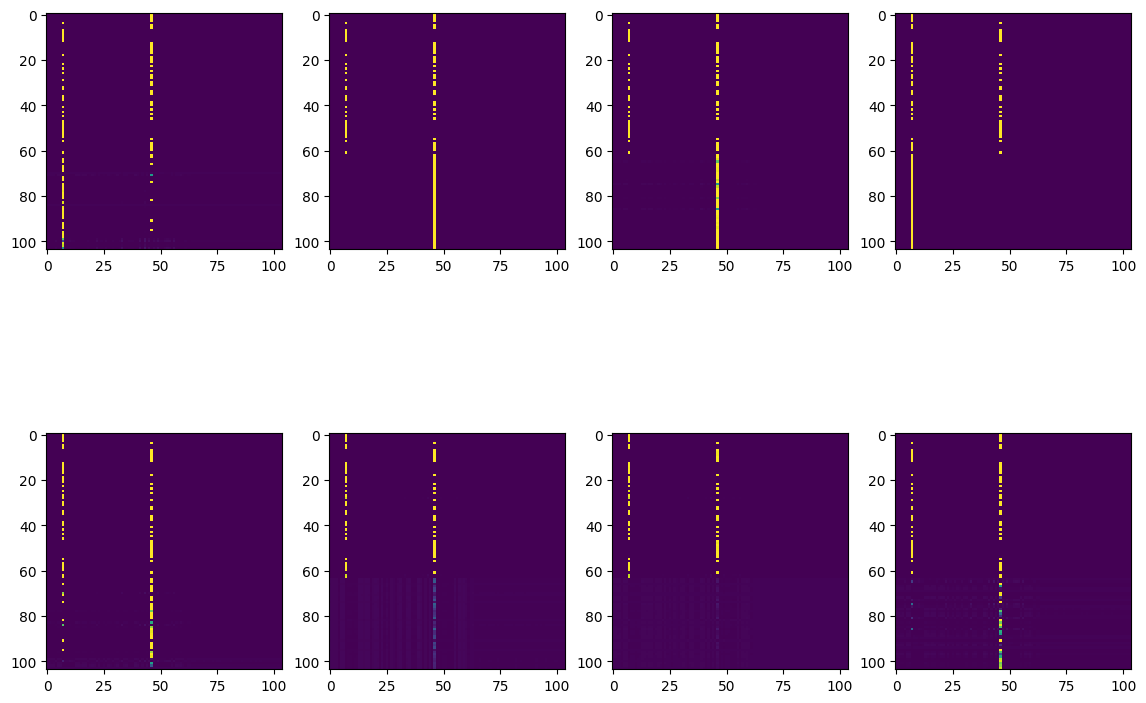

In [11]:
embeddings = pos_embedding1[0].cpu().numpy()
print(embeddings.shape)
f, axarr = plt.subplots(2,4)
axarr[0,0].imshow(embeddings[0], interpolation='none')
axarr[0,1].imshow(embeddings[1], interpolation='none')
axarr[1,0].imshow(embeddings[2], interpolation='none')
axarr[1,1].imshow(embeddings[3], interpolation='none')
axarr[0,2].imshow(embeddings[4], interpolation='none')
axarr[0,3].imshow(embeddings[5], interpolation='none')
axarr[1,2].imshow(embeddings[6], interpolation='none')
axarr[1,3].imshow(embeddings[7], interpolation='none')
plt.show()

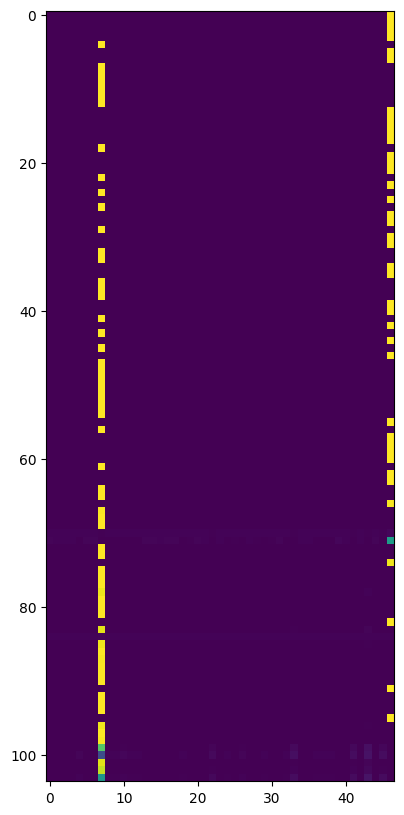

In [12]:
plt.imshow(embeddings[0][:,:47], interpolation='none')
plt.show()

(8, 104, 104)


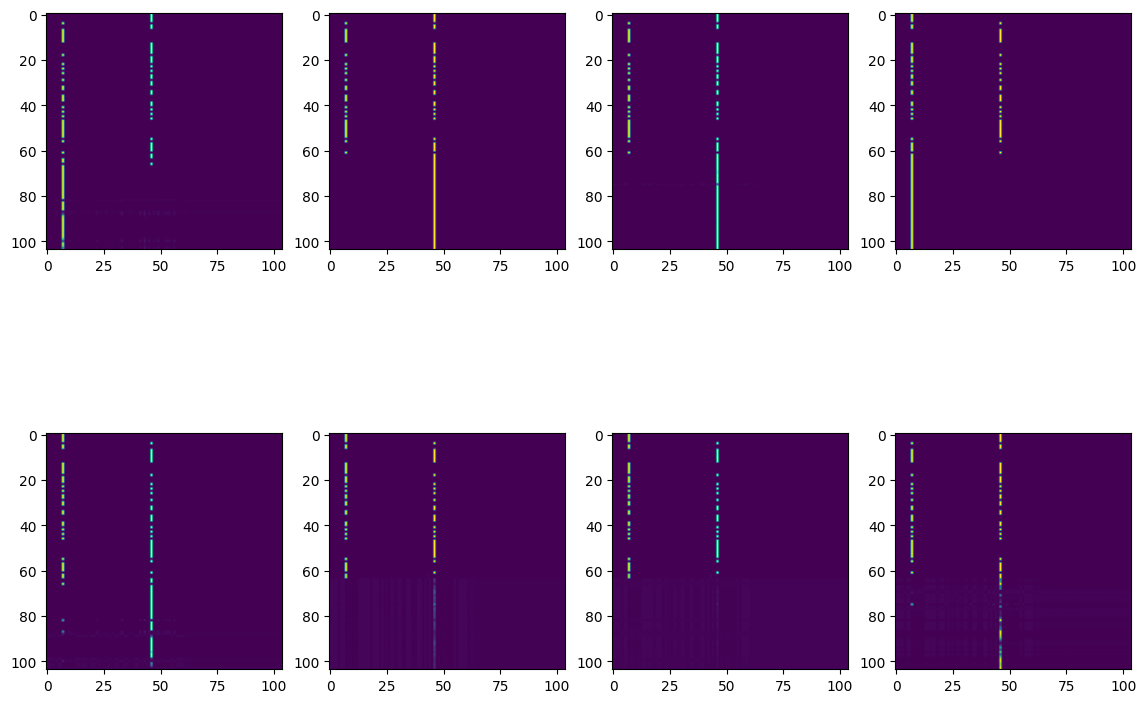

In [13]:
embeddings = pos_embedding2[0].cpu().numpy()
print(embeddings.shape)
f, axarr = plt.subplots(2,4)
axarr[0,0].imshow(embeddings[0])
axarr[0,1].imshow(embeddings[1])
axarr[1,0].imshow(embeddings[2])
axarr[1,1].imshow(embeddings[3])
axarr[0,2].imshow(embeddings[4])
axarr[0,3].imshow(embeddings[5])
axarr[1,2].imshow(embeddings[6])
axarr[1,3].imshow(embeddings[7])
plt.show()

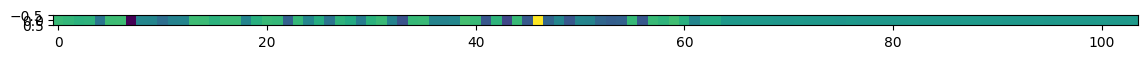

In [14]:
fused_combined = pos_fuse[:,:,0].cpu().numpy()
plt.imshow(fused_combined, interpolation="none")
plt.show()

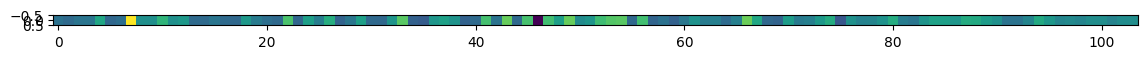

In [15]:
fused_diff = (pos_fuse-neg_fuse)[:,:,0].cpu().numpy()
plt.imshow(fused_diff, interpolation="none")
plt.show()

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [3.68283549e-03 4.03562747e-03 4.39955108e-03 ... 7.26807630e-03
   7.37986062e-03 7.35236146e-03]
  [2.66790696e-08 4.38942429e-08 7.02260650e-08 ... 1.07918368e-06
   1.17266552e-06 1.14907766e-06]
  [8.37904167e-07 1.24812232e-06 1.81802091e-06 ... 1.61911776e-05
   1.73042772e-05 1.70251351e-05]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [4.85114880e-16 5.67825411e-17 7.49745009e-18 ... 5.78901473e-23
   4.04729

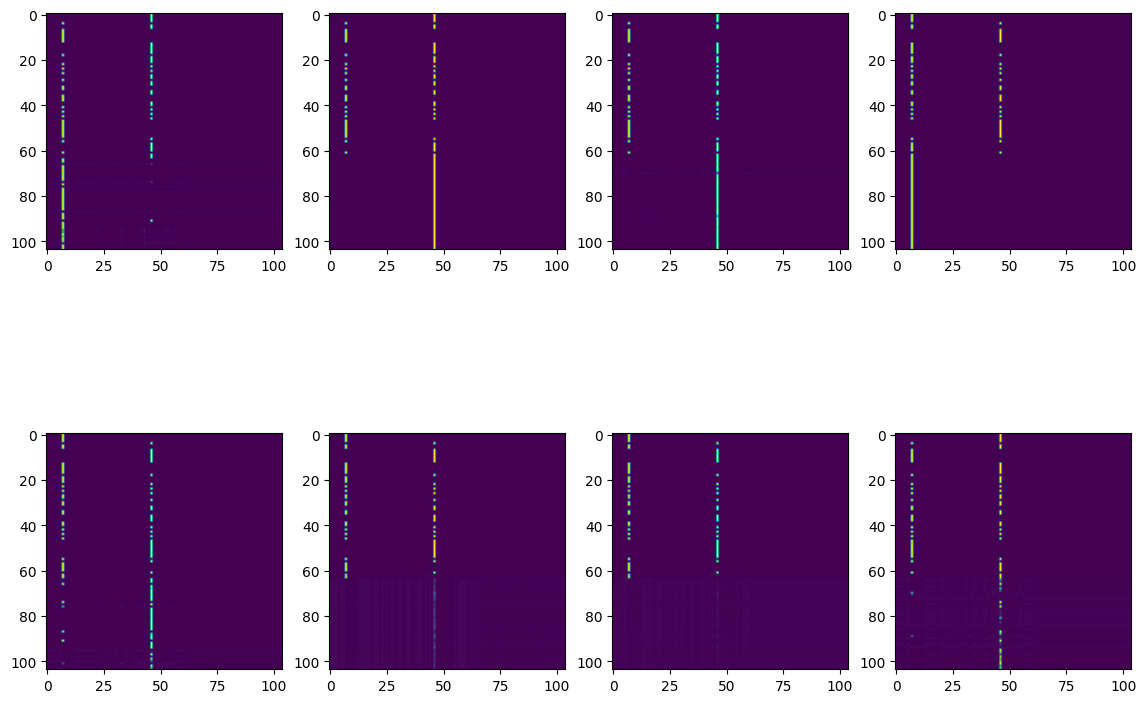

In [16]:
embeddings = neg_embedding1[0].cpu().numpy()
print(embeddings)
f, axarr = plt.subplots(2,4)
axarr[0,0].imshow(embeddings[0])
axarr[0,1].imshow(embeddings[1])
axarr[1,0].imshow(embeddings[2])
axarr[1,1].imshow(embeddings[3])
axarr[0,2].imshow(embeddings[4])
axarr[0,3].imshow(embeddings[5])
axarr[1,2].imshow(embeddings[6])
axarr[1,3].imshow(embeddings[7])
plt.show()

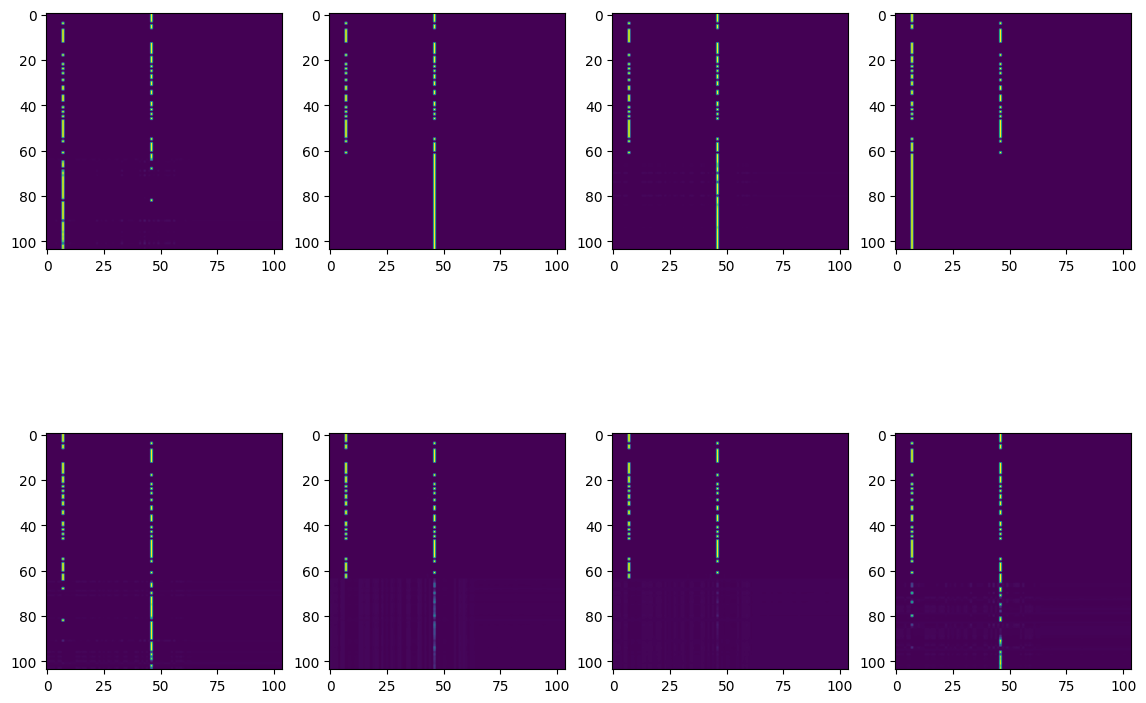

In [17]:
embeddings = neg_embedding2[0].cpu().numpy()
f, axarr = plt.subplots(2,4)
axarr[0,0].imshow(embeddings[0])
axarr[0,1].imshow(embeddings[1])
axarr[1,0].imshow(embeddings[2])
axarr[1,1].imshow(embeddings[3])
axarr[0,2].imshow(embeddings[4])
axarr[0,3].imshow(embeddings[5])
axarr[1,2].imshow(embeddings[6])
axarr[1,3].imshow(embeddings[7])
plt.show()

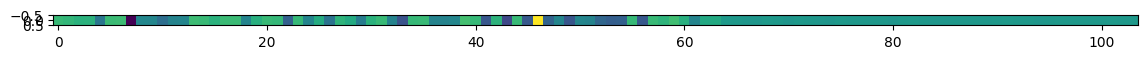

In [18]:
fused_combined = neg_fuse[:,:,0].cpu().numpy()
plt.imshow(fused_combined, interpolation="none")
plt.show()

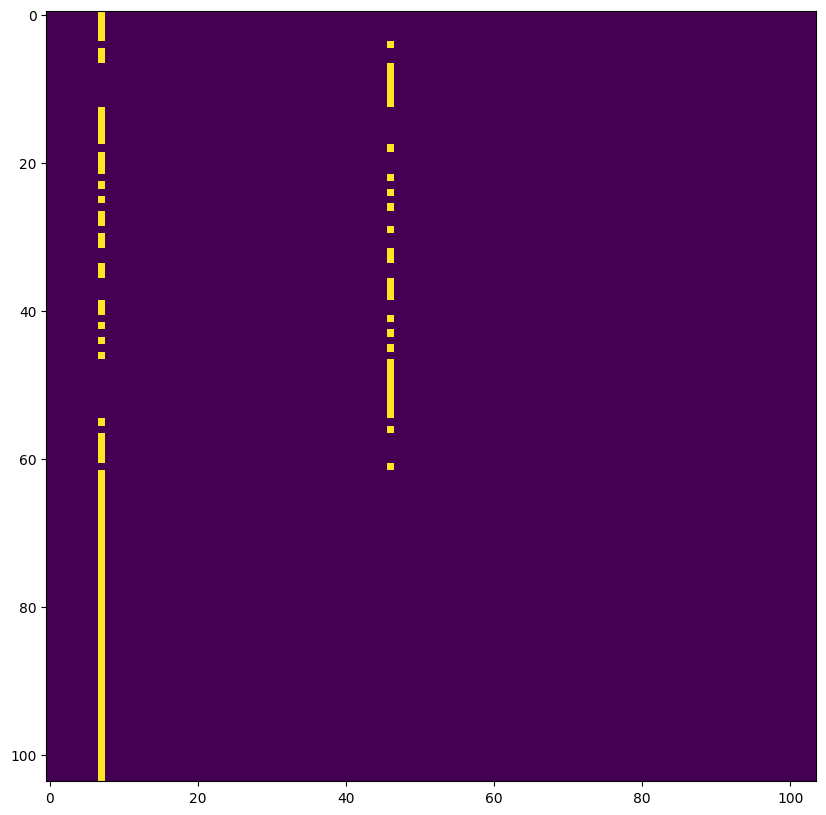

In [19]:
plt.imshow(embeddings[5], interpolation='none')
plt.savefig('foo.png')
plt.show()

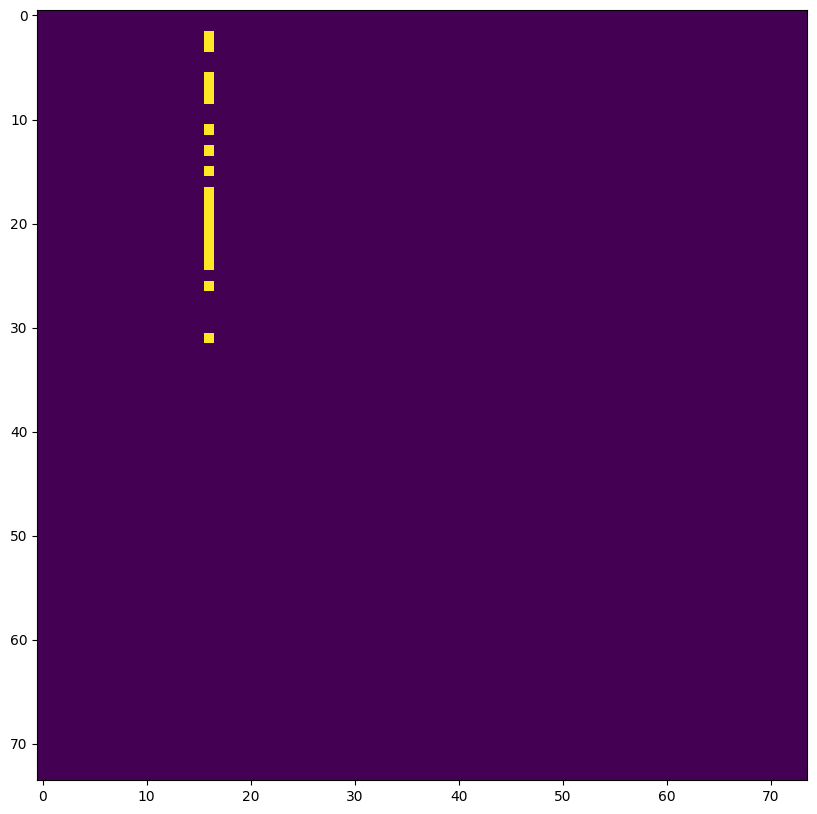

In [20]:
plt.imshow(embeddings[5][30:, 30:], interpolation='none')
plt.show()

In [21]:
model.eval()
neg_fuse = 0
neg_total = 0
pos_fuse = 0 
pos_total = 0
with torch.no_grad():
    for i, (graph_data, sequence_data, target, peptide_property) in enumerate(test_loader):
        graph_data = graph_data.to(device)
        sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)
        embeddings, fused_combined, _, final_output = model(graph_data, sequence_data, peptide_property, return_attention = True)
        embeddings = embeddings[0].cpu().numpy()
        probs = torch.sigmoid(final_output).squeeze()
        if probs >= 0.5 and target == 0:
            continue
        elif probs < 0.5 and target == 1:
            continue
        
        # f, axarr = plt.subplots(2,4)
        # axarr[0,0].imshow(embeddings[0], interpolation='none')
        # axarr[0,1].imshow(embeddings[1], interpolation='none')
        # axarr[1,0].imshow(embeddings[2], interpolation='none')
        # axarr[1,1].imshow(embeddings[3], interpolation='none')
        # axarr[0,2].imshow(embeddings[4], interpolation='none')
        # axarr[0,3].imshow(embeddings[5], interpolation='none')
        # axarr[1,2].imshow(embeddings[6], interpolation='none')
        # axarr[1,3].imshow(embeddings[7], interpolation='none')
        if target == 1:
            # plt.savefig("pos" + str(i) + ".png")
            pos_fuse += fused_combined
            pos_total+=1
        else:
            # plt.savefig("neg" + str(i) + ".png")
            neg_fuse += fused_combined
            neg_total+=1
        # plt.close()

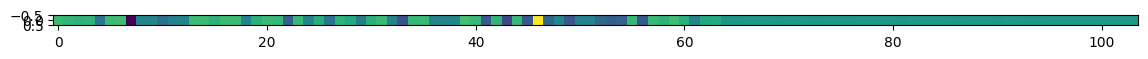

[ 18.318695  15.752795  13.60827   14.248077 -17.245173  18.706093
  19.515789 -64.82452   -9.210064  -9.381244] [ 17.246265 -31.903656  14.696973 -38.744167  17.542692 -31.017328
  57.05138  -25.50648   -9.167562]
[ 17.72485   16.501554 -27.569025  16.74447   -9.486706  11.081579
 -18.07442   13.889623   9.519151 -13.699945] [ 17.388468    14.598286    19.5634      12.539642   -10.467305
   9.034595     9.86195     -0.38012356]


In [22]:
fused_combined = pos_fuse[:,:,0].cpu().numpy()/pos_total
plt.imshow(fused_combined, interpolation="none")
plt.show()
print(fused_combined[0][:10], fused_combined[0][40:49]) # model 2
print(fused_combined[0][20:30], fused_combined[0][57:65]) # model 3

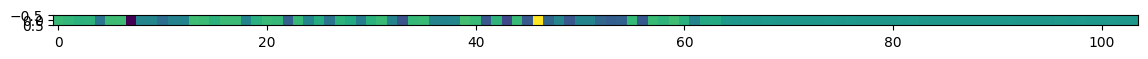

[ 18.35386   16.110016  13.688042  14.292612 -17.497442  18.945404
  19.646536 -66.05398   -9.034658  -9.399825] [ 17.477993 -32.442715  14.751108 -39.363953  17.690426 -31.488276
  58.169846 -26.134588  -9.398099]
[ 17.825102  16.694967 -28.113987  17.012732  -9.700192  10.968883
 -18.449091  14.398279   9.664035 -13.93733 ] [ 17.821533    14.72475     19.935162    12.56697    -10.356406
   9.106867     9.79205      0.04042284]


In [23]:
fused_combined = neg_fuse[:,:,0].cpu().numpy()/neg_total
plt.imshow(fused_combined, interpolation="none")
plt.show()
print(fused_combined[0][:10], fused_combined[0][40:49]) # model 2
print(fused_combined[0][20:30], fused_combined[0][57:65]) # model 3

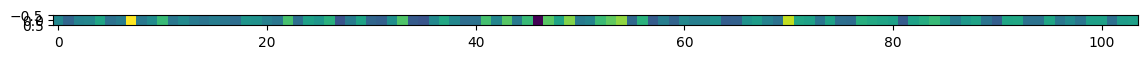

In [24]:
fused_combined = (pos_fuse/pos_total-neg_fuse/neg_total)[:,:,0].cpu().numpy()
plt.imshow(fused_combined, interpolation="none")
plt.show()

# x_gate_node (64), z_vae (32), peptide_property (8)

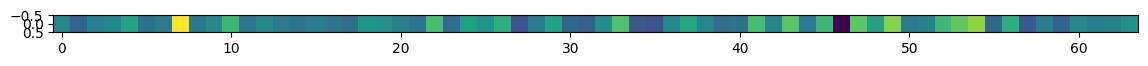

In [25]:
fused_combined = (pos_fuse/pos_total-neg_fuse/neg_total)[:,:,0].cpu().numpy()
plt.imshow(fused_combined[:, :64], interpolation="none")
plt.show()

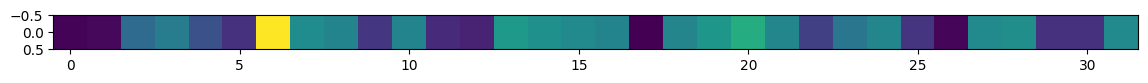

In [26]:
fused_combined = (pos_fuse/pos_total-neg_fuse/neg_total)[:,:,0].cpu().numpy()
plt.imshow(fused_combined[:, 64:96], interpolation="none")
plt.show()

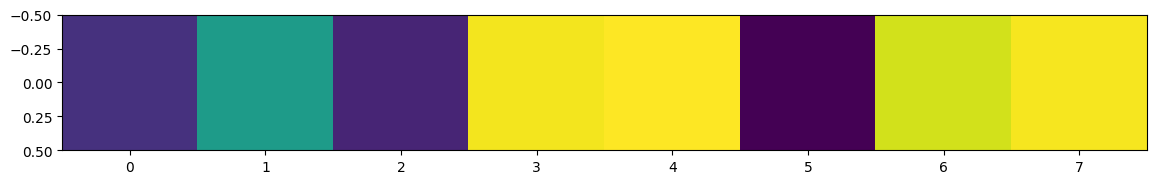

In [27]:
fused_combined = (pos_fuse/pos_total-neg_fuse/neg_total)[:,:,0].cpu().numpy()
plt.imshow(fused_combined[:, 96:], interpolation="none")
plt.show()

In [28]:
model.eval()
neg_fuse = 0
neg_total = 0
pos_fuse = 0 
pos_total = 0
with torch.no_grad():
    for i, (graph_data, sequence_data, target, peptide_property) in enumerate(test_loader):
        graph_data = graph_data.to(device)
        sequence_data, target, peptide_property = sequence_data.to(device), target.to(device), peptide_property.to(device)
        embeddings, fused_combined, _, final_output = model(graph_data, sequence_data, peptide_property, return_attention = True)
        embeddings = embeddings[0].cpu().numpy()
        probs = torch.sigmoid(final_output).squeeze()
        if probs >= 0.5 and target == 0:
            continue
        elif probs < 0.5 and target == 1:
            continue
        
        # f, axarr = plt.subplots(2,4)
        # axarr[0,0].imshow(embeddings[0], interpolation='none')
        # axarr[0,1].imshow(embeddings[1], interpolation='none')
        # axarr[1,0].imshow(embeddings[2], interpolation='none')
        # axarr[1,1].imshow(embeddings[3], interpolation='none')
        # axarr[0,2].imshow(embeddings[4], interpolation='none')
        # axarr[0,3].imshow(embeddings[5], interpolation='none')
        # axarr[1,2].imshow(embeddings[6], interpolation='none')
        # axarr[1,3].imshow(embeddings[7], interpolation='none')
        if target == 1:
            # plt.savefig("pos" + str(i) + ".png")
            pos_fuse += embeddings
            pos_total+=1
        else:
            # plt.savefig("neg" + str(i) + ".png")
            neg_fuse += embeddings
            neg_total+=1
        # plt.close()

C:\Users\edwar\AppData\Local\Temp\ipykernel_5916\3866364587.py:2: RuntimeWarning: divide by zero encountered in log
  embeddings = np.log(neg_fuse/ neg_total)


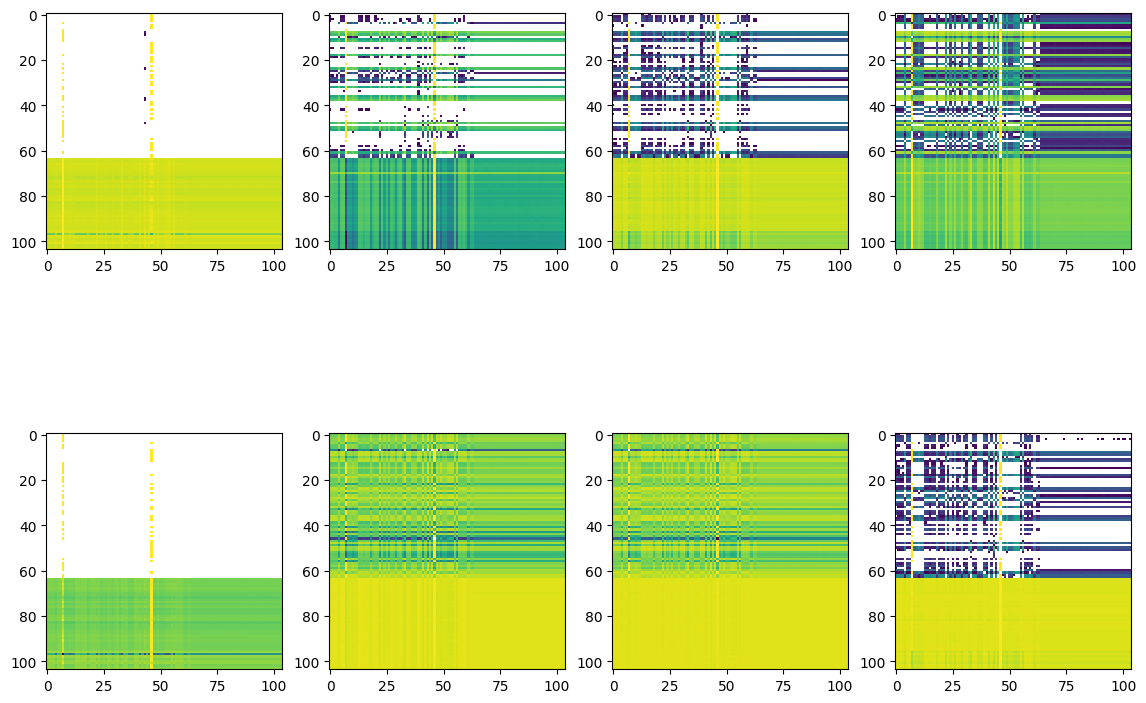

In [29]:
f, axarr = plt.subplots(2,4)
embeddings = np.log(neg_fuse/ neg_total)
axarr[0,0].imshow(embeddings[0], interpolation='none')
axarr[0,1].imshow(embeddings[1], interpolation='none')
axarr[1,0].imshow(embeddings[2], interpolation='none')
axarr[1,1].imshow(embeddings[3], interpolation='none')
axarr[0,2].imshow(embeddings[4], interpolation='none')
axarr[0,3].imshow(embeddings[5], interpolation='none')
axarr[1,2].imshow(embeddings[6], interpolation='none')
axarr[1,3].imshow(embeddings[7], interpolation='none')
plt.show()

C:\Users\edwar\AppData\Local\Temp\ipykernel_5916\543306207.py:2: RuntimeWarning: divide by zero encountered in log
  embeddings = np.log(pos_fuse/ pos_total)


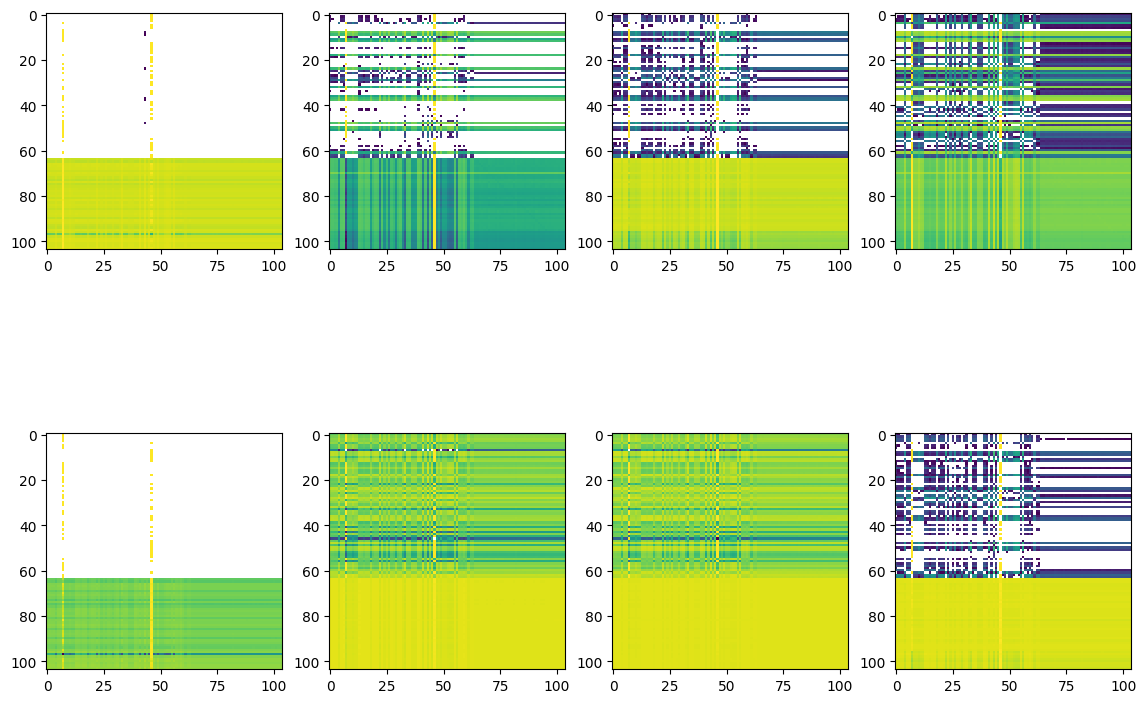

In [30]:
f, axarr = plt.subplots(2,4)
embeddings = np.log(pos_fuse/ pos_total)
axarr[0,0].imshow(embeddings[0], interpolation='none')
axarr[0,1].imshow(embeddings[1], interpolation='none')
axarr[1,0].imshow(embeddings[2], interpolation='none')
axarr[1,1].imshow(embeddings[3], interpolation='none')
axarr[0,2].imshow(embeddings[4], interpolation='none')
axarr[0,3].imshow(embeddings[5], interpolation='none')
axarr[1,2].imshow(embeddings[6], interpolation='none')
axarr[1,3].imshow(embeddings[7], interpolation='none')
plt.show()

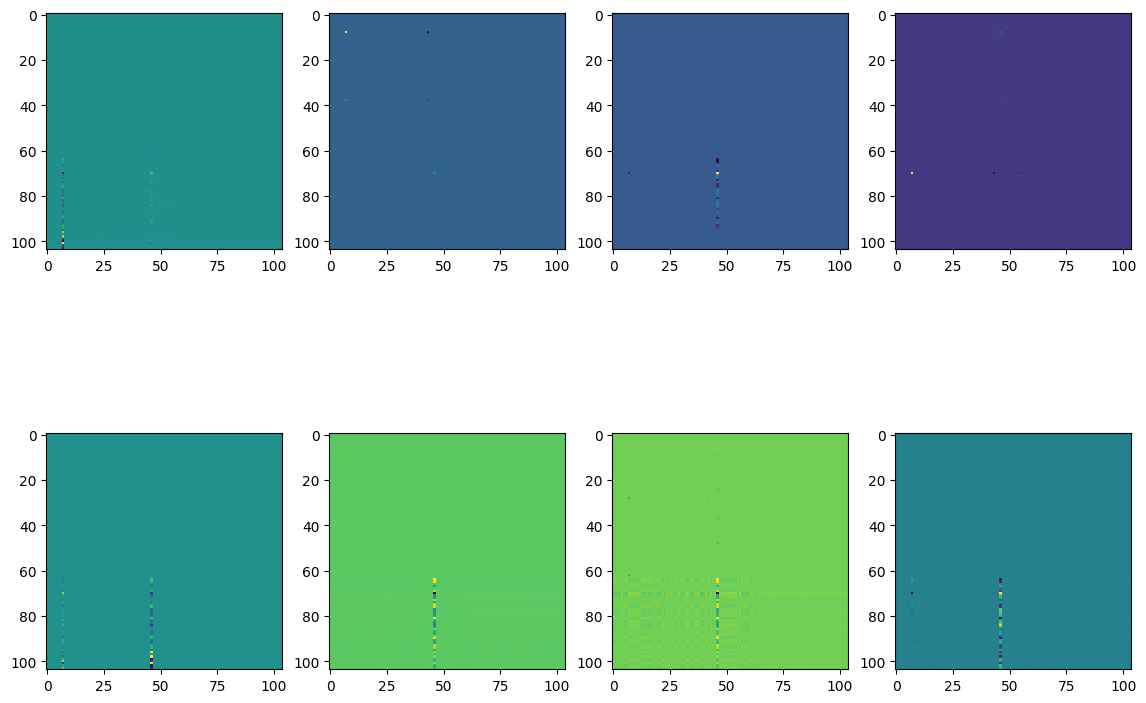

In [31]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

f, axarr = plt.subplots(2,4)
embeddings = sigmoid(pos_fuse/ pos_total - neg_fuse/ neg_total)
axarr[0,0].imshow(embeddings[0], interpolation='none')
axarr[0,1].imshow(embeddings[1], interpolation='none')
axarr[1,0].imshow(embeddings[2], interpolation='none')
axarr[1,1].imshow(embeddings[3], interpolation='none')
axarr[0,2].imshow(embeddings[4], interpolation='none')
axarr[0,3].imshow(embeddings[5], interpolation='none')
axarr[1,2].imshow(embeddings[6], interpolation='none')
axarr[1,3].imshow(embeddings[7], interpolation='none')
plt.show()

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


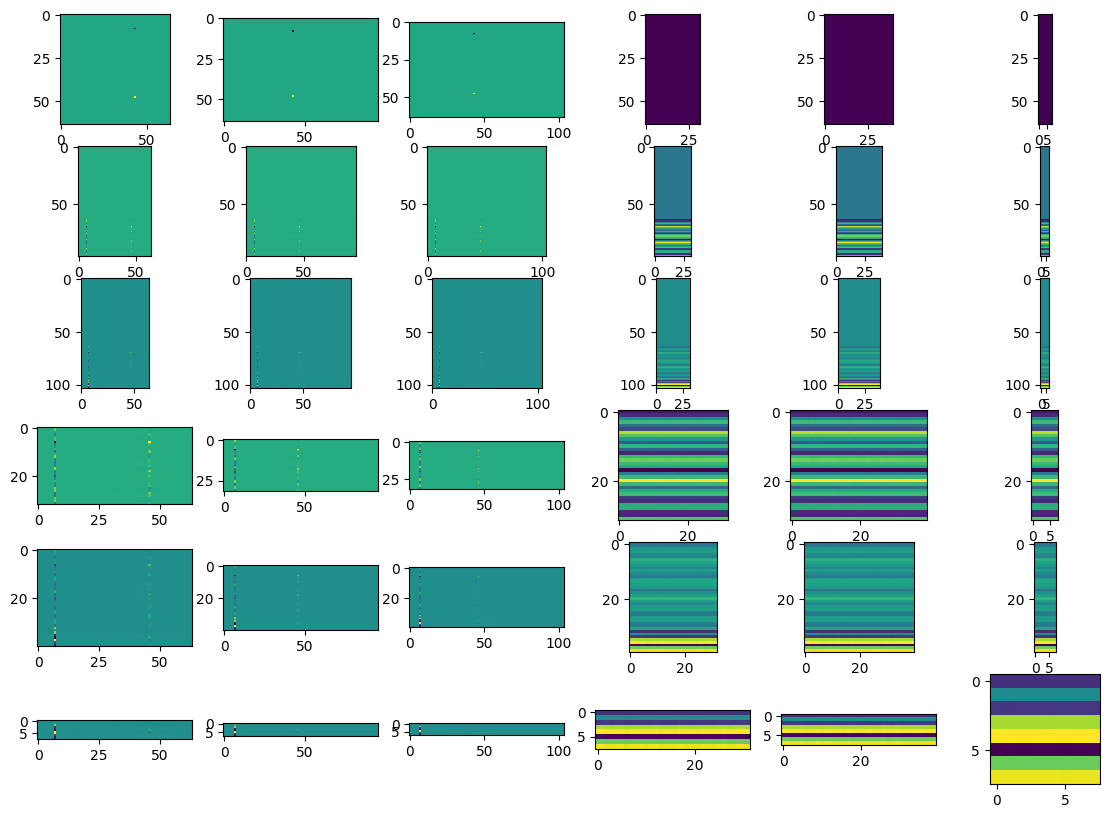

In [32]:
splits = [0, 64, 96, 105]
combos = []
for i in range(len(splits)):
    for j in range(i, len(splits)):
        combos.append((i, j))

for i in range(len(splits)):
    combos.remove((i,i))

print(combos)

combo2d = []
for i in range(len(combos)):
    for j in range(len(combos)):
        combo2d.append((combos[i], combos[j]))

f, axarr = plt.subplots(6,6)
embeddings = (pos_fuse/ pos_total - neg_fuse/ neg_total)[0]
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(embeddings[startx: endx, starty:endy], interpolation='none')

plt.show()

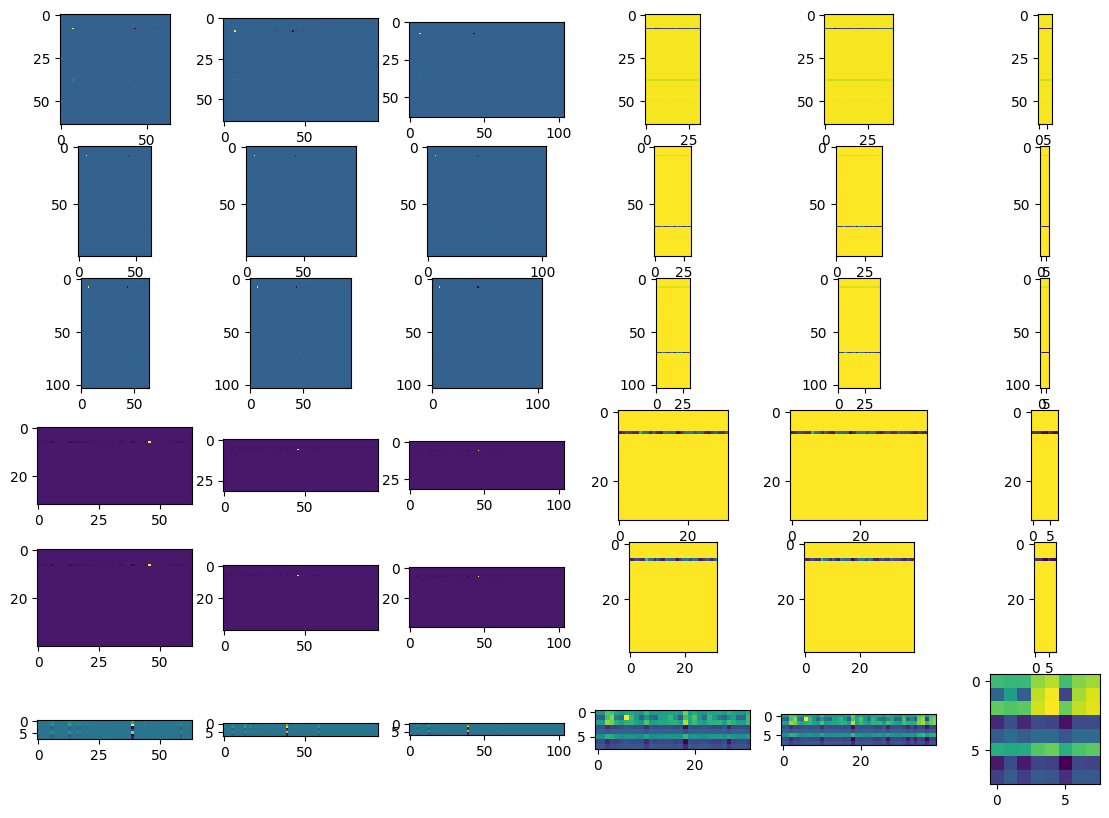

In [33]:
f, axarr = plt.subplots(6,6)
embeddings = (pos_fuse/ pos_total - neg_fuse/ neg_total)[1]
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(embeddings[startx: endx, starty:endy], interpolation='none')
plt.savefig("bar.png")
plt.show()

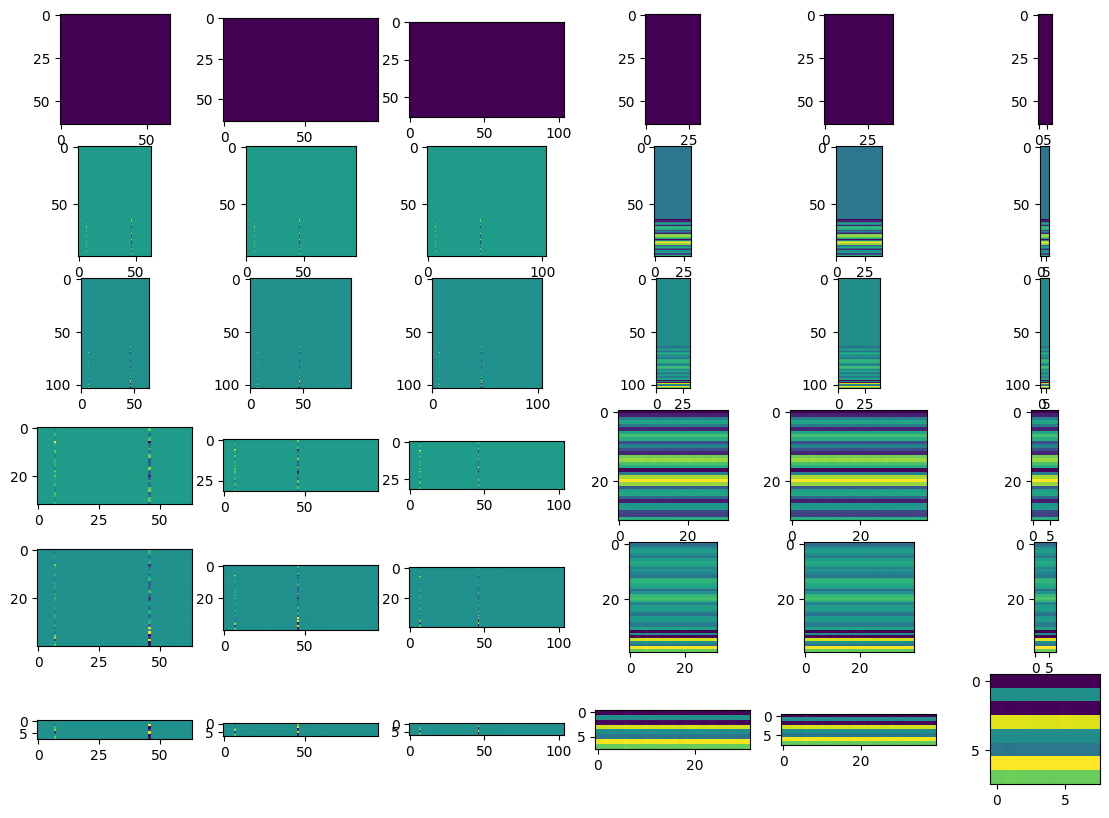

In [34]:
f, axarr = plt.subplots(6,6)
embeddings = (pos_fuse/ pos_total - neg_fuse/ neg_total)[2]
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(embeddings[startx: endx, starty:endy], interpolation='none')

plt.show()

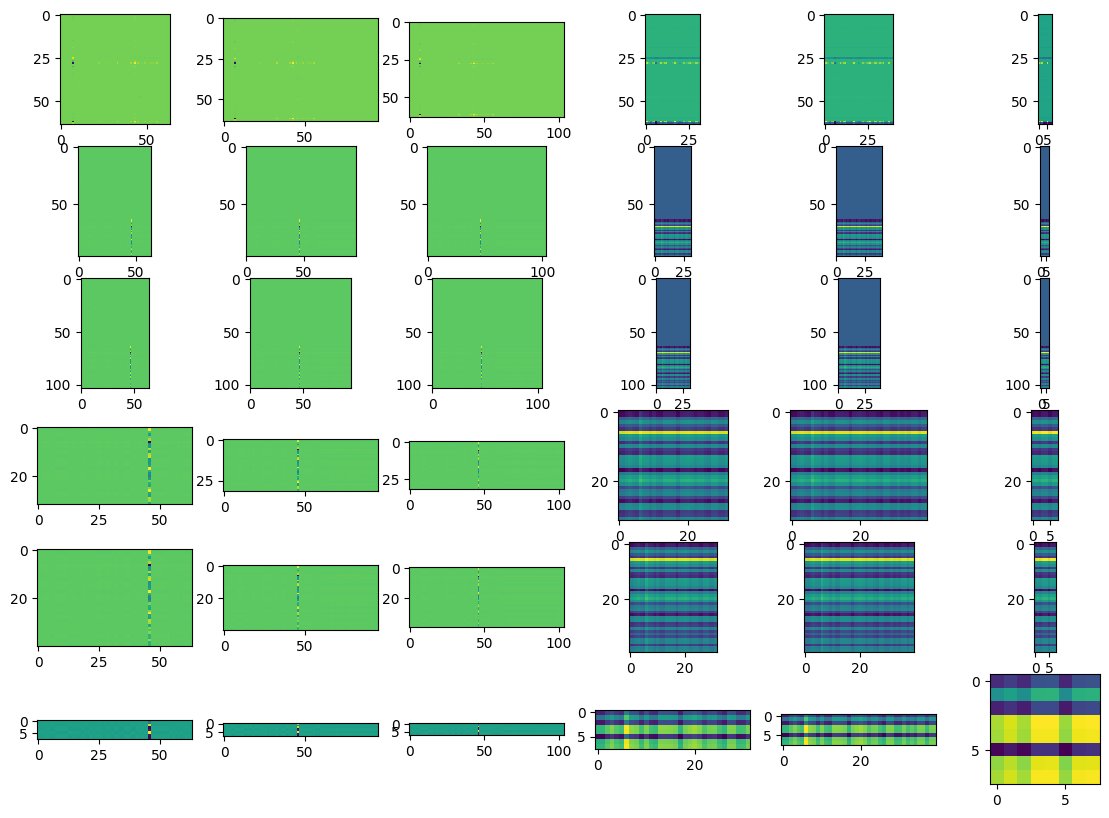

In [35]:
f, axarr = plt.subplots(6,6)
embeddings = (pos_fuse/ pos_total - neg_fuse/ neg_total)[3]
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(embeddings[startx: endx, starty:endy], interpolation='none')

plt.show()

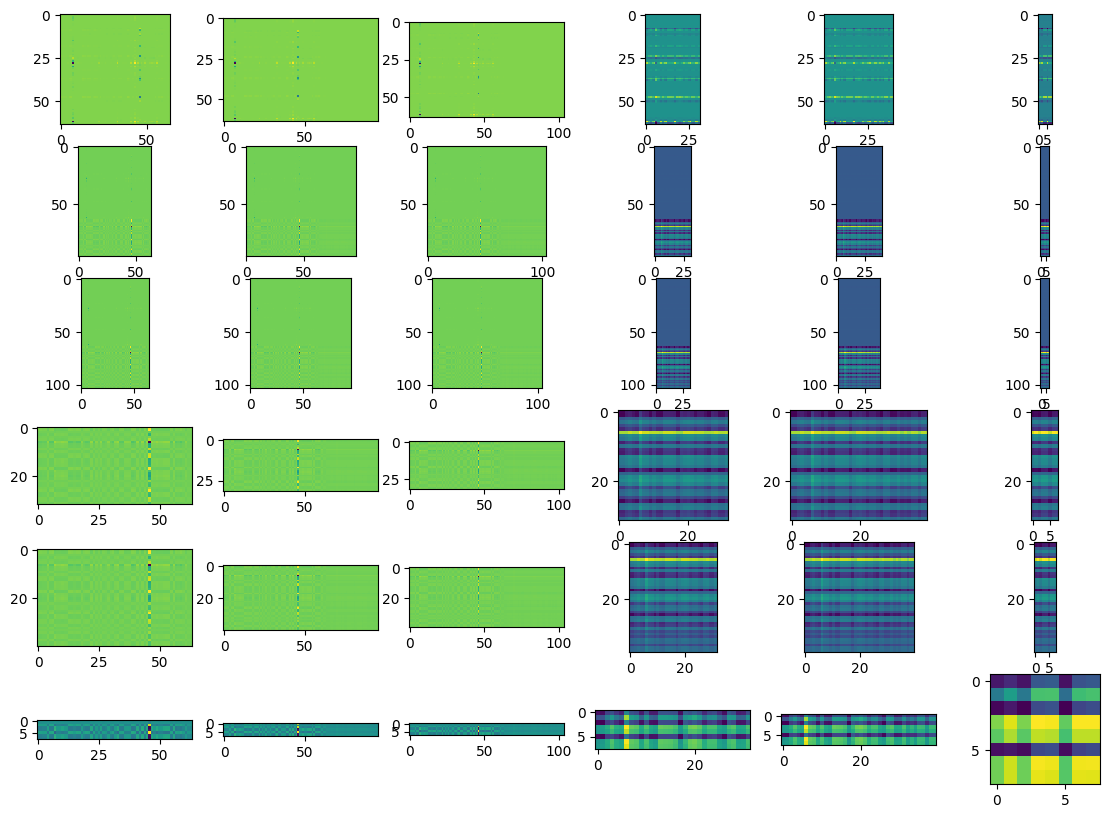

In [36]:
f, axarr = plt.subplots(6,6)
embeddings = (pos_fuse/ pos_total - neg_fuse/ neg_total)[6]
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(embeddings[startx: endx, starty:endy], interpolation='none')
plt.savefig("foo.png")
plt.show()

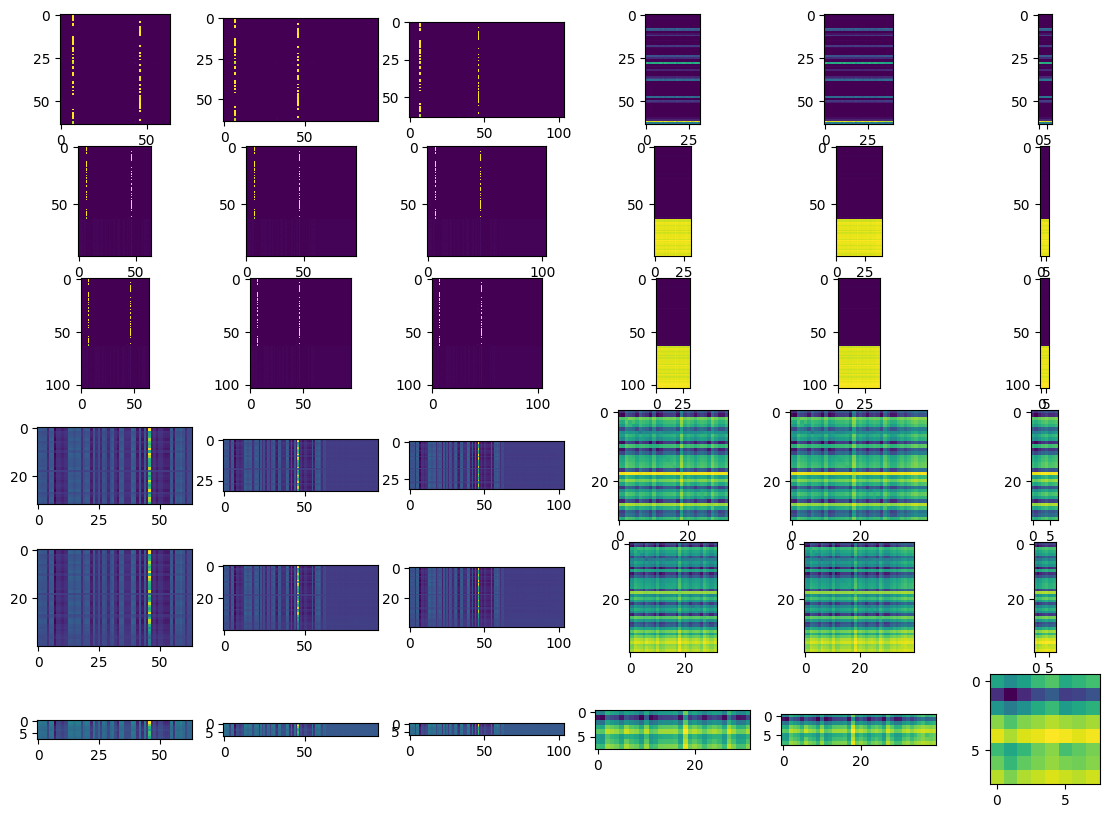

In [37]:
f, axarr = plt.subplots(6,6)
embeddings = (pos_fuse/ pos_total)[6]
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(embeddings[startx: endx, starty:endy], interpolation='none')

plt.show()

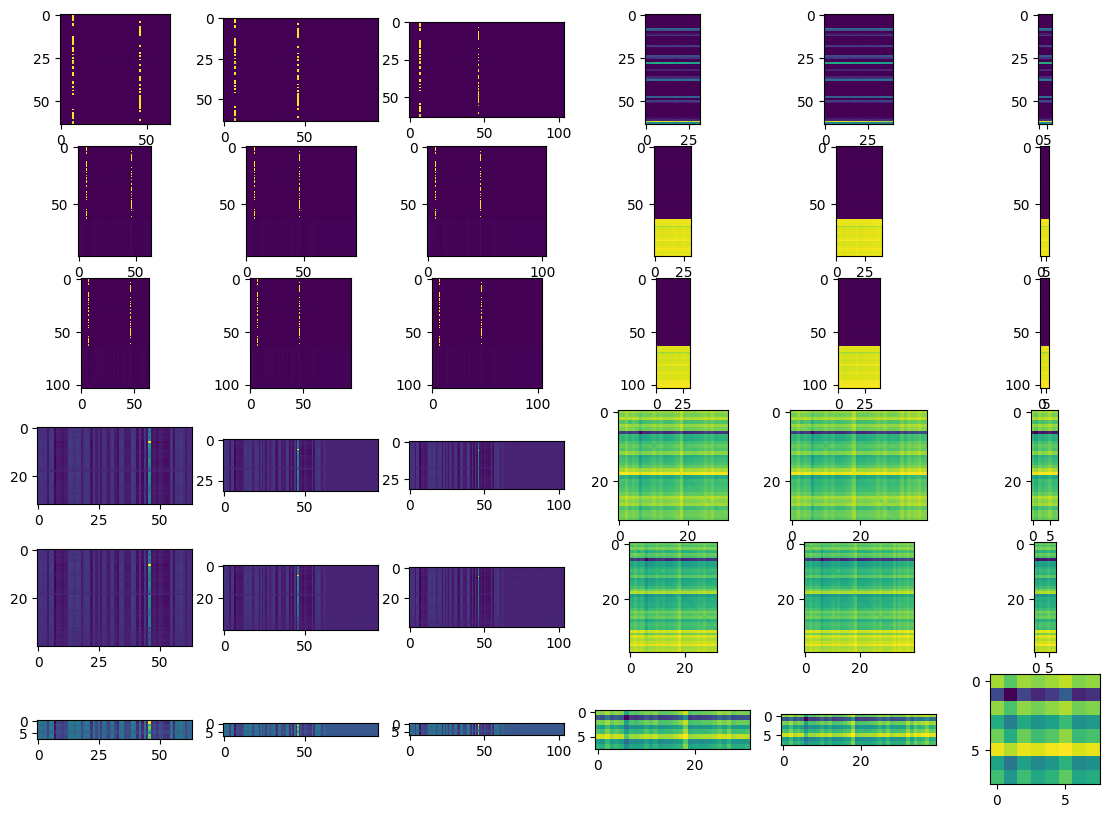

In [38]:
f, axarr = plt.subplots(6,6)
embeddings = (neg_fuse/ neg_total)[6]
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(embeddings[startx: endx, starty:endy], interpolation='none')

plt.show()

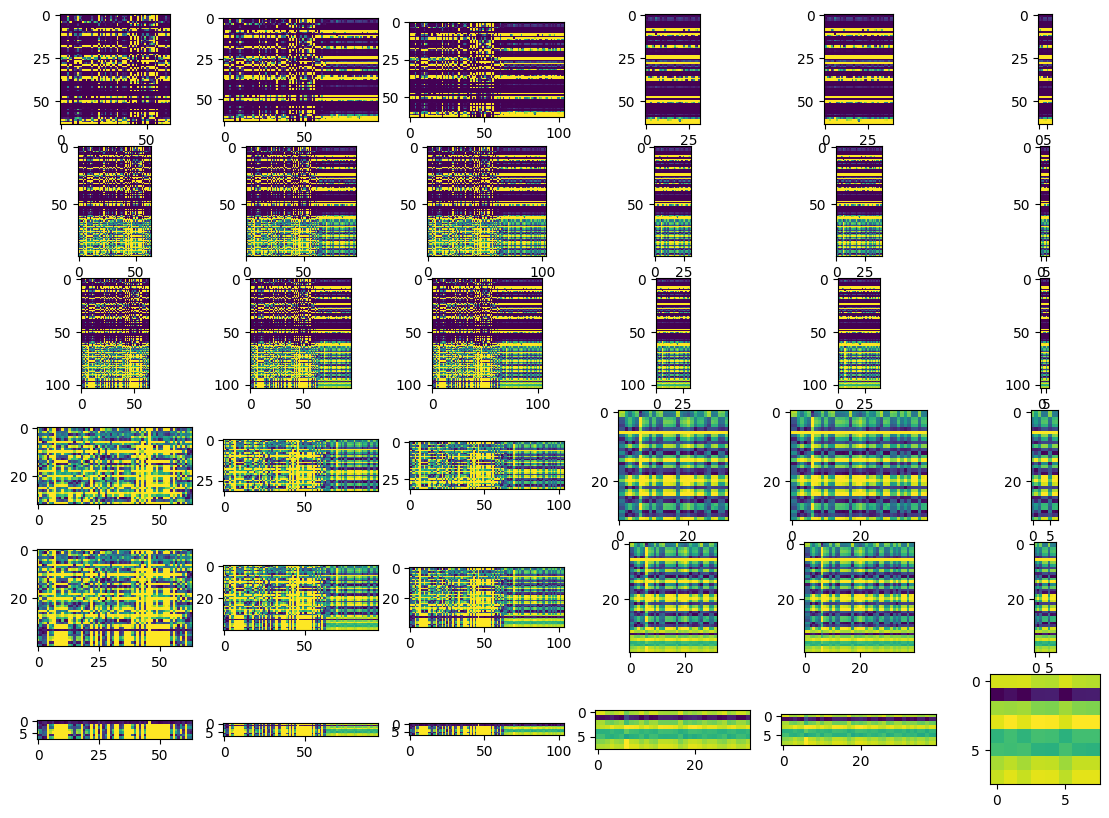

In [47]:
# for just structure attention map
# new_embedding = np.clip(np.max(np.abs((pos_fuse/ pos_total - neg_fuse/ neg_total)), axis=0), 0, 0.00001)

# for just sequence attention map
# new_embedding = np.clip(np.abs(np.mean((pos_fuse/ pos_total - neg_fuse/ neg_total), axis=0)), 0, 0.0001)

# for just mprops attention map
# new_embedding = np.clip(np.abs(np.mean((pos_fuse/ pos_total - neg_fuse/ neg_total), axis=0)), 0, 0.0006)

pos = np.clip(np.max(np.abs(pos_fuse/ pos_total), axis=0), 0, 0.001)
neg = np.clip(np.max(np.abs(neg_fuse/ neg_total), axis=0), 0, 0.001)
new_embedding = np.clip(np.abs(pos-neg), 0, 0.000001)

# [0, 64, 96, 105]
new_embedding = np.zeros((104, 104))
embedding = (pos_fuse/ pos_total - neg_fuse/ neg_total)
new_embedding[:64] = np.clip(np.abs(pos-neg)[:64], 0, 0.000001) * 1e6
new_embedding[64:96] = np.clip(np.abs(np.mean(embedding[:,64:96], axis=0)), 0, 1e-4) * 1e4
new_embedding[96:] = np.clip(np.abs(np.mean(embedding[:,96:], axis=0)), 0, 0.0006) * 1.0 / 0.0006
f, axarr = plt.subplots(6,6)
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(new_embedding[startx: endx, starty:endy], interpolation='none')

plt.show()


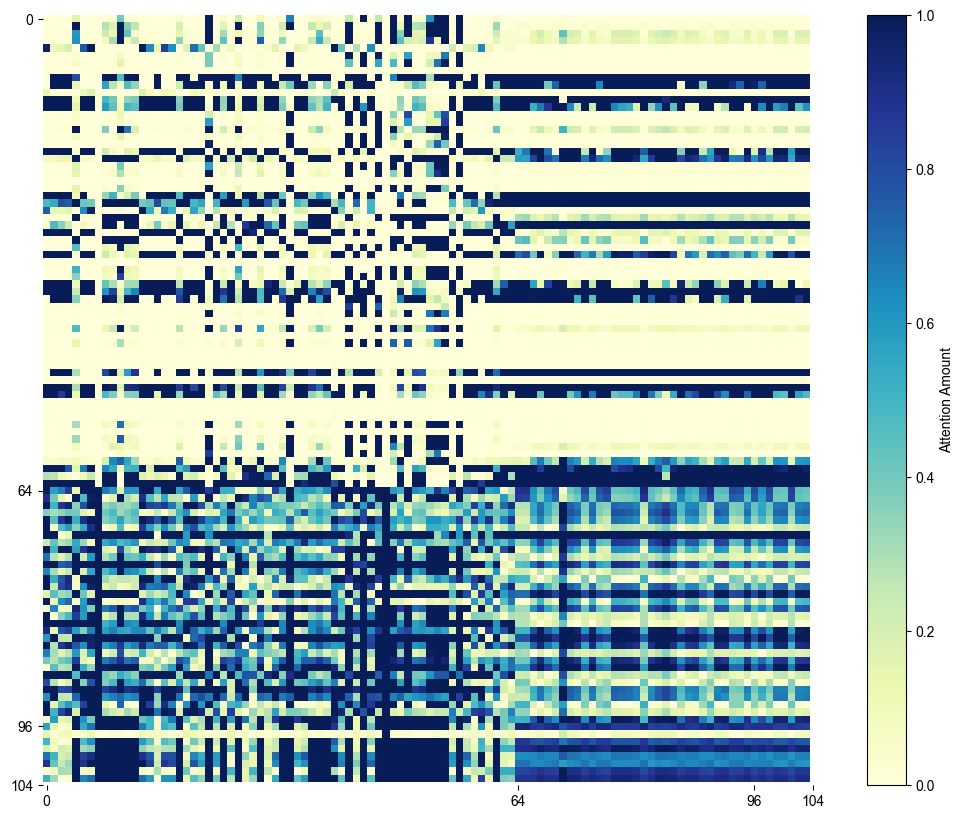

In [55]:
import matplotlib as mpl

plt.imshow(new_embedding, interpolation="none", cmap=mpl.colormaps["YlGnBu"])
ticks = [0, 64, 96, 104]
plt.xticks(ticks)
plt.yticks(ticks)
plt.box(False)
plt.rcParams['font.family'] = 'Arial'
plt.colorbar(label="Attention Amount", orientation="vertical") 
plt.show()

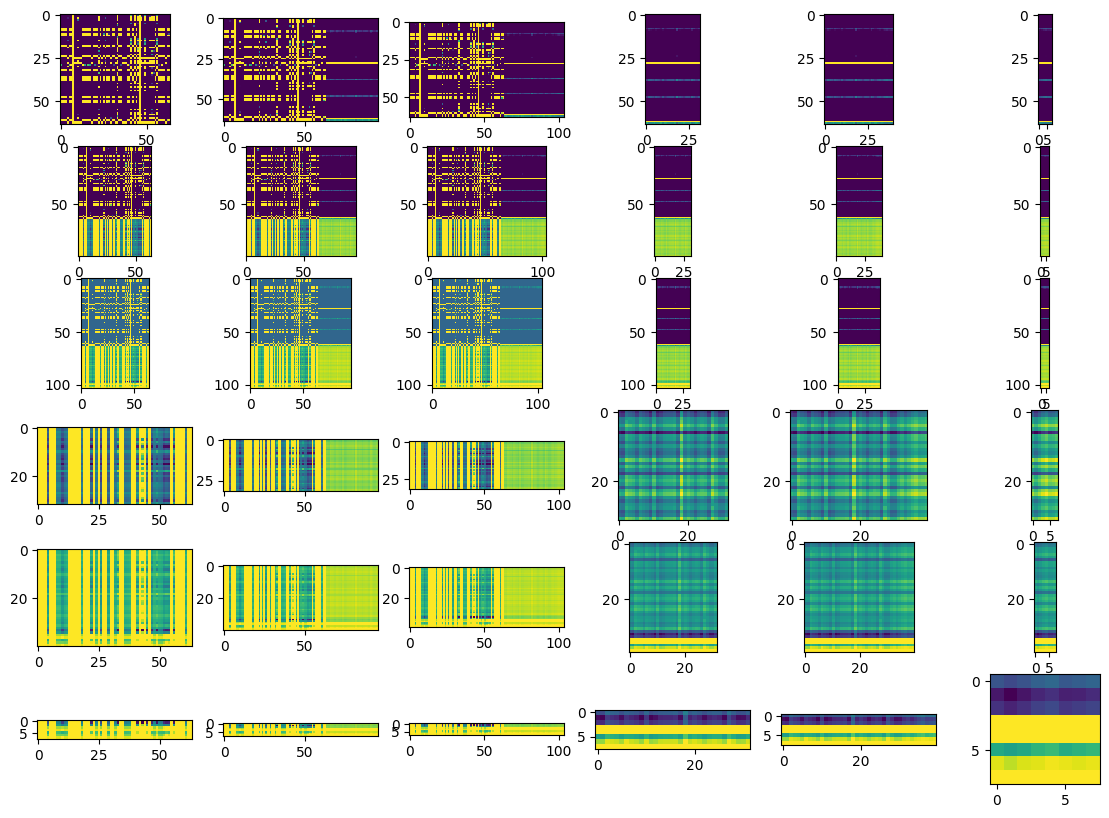

In [41]:
# sequence and properties
# new_embedding = (np.mean(pos_fuse/ pos_total, axis=0))

# structure
# new_embedding = np.clip(np.max(np.abs(pos_fuse/ pos_total), axis=0), 0, 0.001)

new_embedding = np.zeros((104, 104))
embedding = (pos_fuse/ pos_total)
new_embedding[:64] = np.clip(np.max(np.abs(embedding)[:, :64], axis=0), 5e-5, 1e-4) * 1e4
new_embedding[64:] = np.clip(np.mean(np.abs(embedding[:,64:]), axis=0), 0, 0.003) / 0.003
f, axarr = plt.subplots(6,6)
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(new_embedding[startx: endx, starty:endy], interpolation='none')

plt.show()

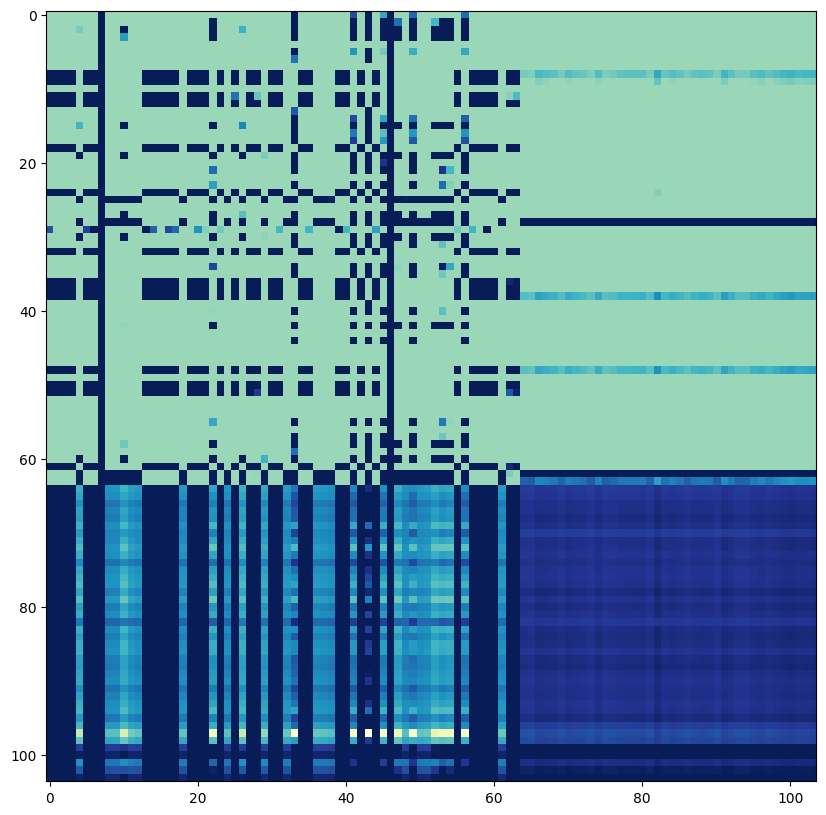

In [42]:
plt.imshow(new_embedding, interpolation="none", cmap=mpl.colormaps["YlGnBu"])
plt.show()

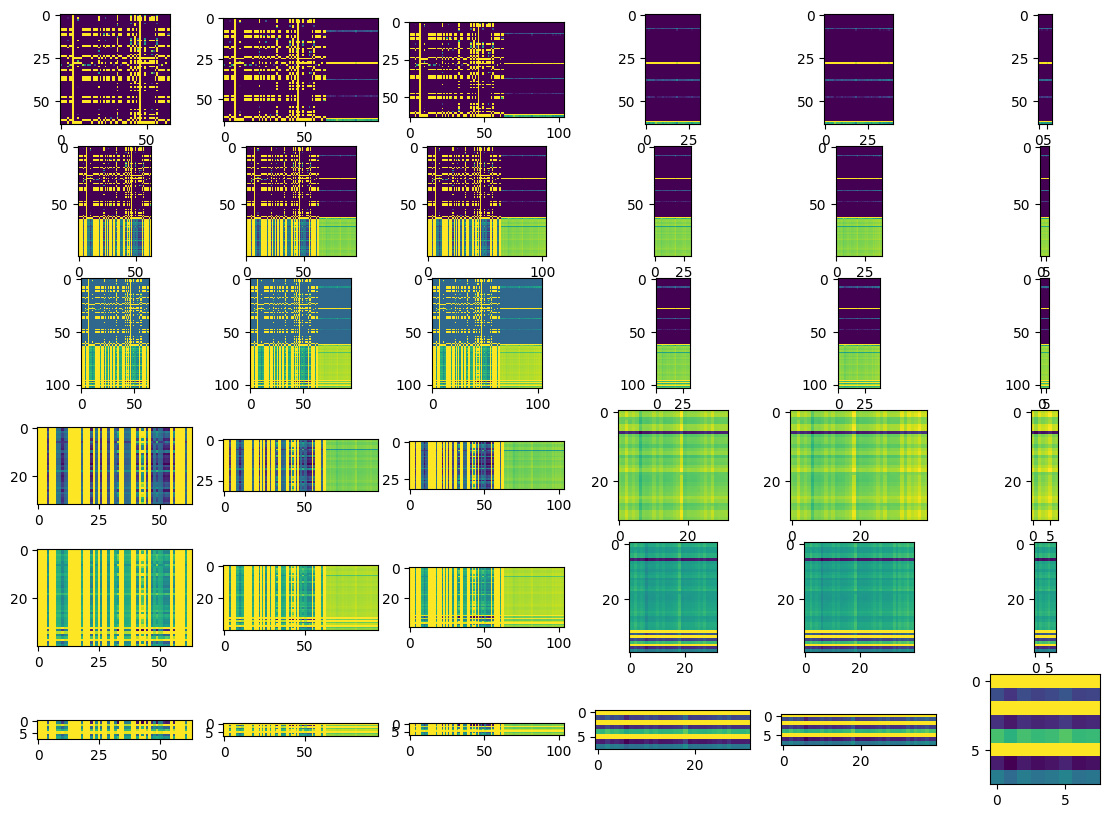

In [43]:
# structure
# new_embedding = np.clip(np.max(np.abs(neg_fuse/ neg_total), axis=0), 0, 0.001)

# sequence and properties
# new_embedding = (np.mean(neg_fuse/ neg_total, axis=0))


new_embedding = np.zeros((104, 104))
embedding = (neg_fuse/ neg_total)
new_embedding[:64] = np.clip(np.max(np.abs(embedding)[:, :64], axis=0), 5e-5, 1e-4) * 1e4
new_embedding[64:] = np.clip(np.mean(np.abs(embedding[:,64:]), axis=0), 0, 0.003) / 0.003
f, axarr = plt.subplots(6,6)
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(new_embedding[startx: endx, starty:endy], interpolation='none')

plt.show()

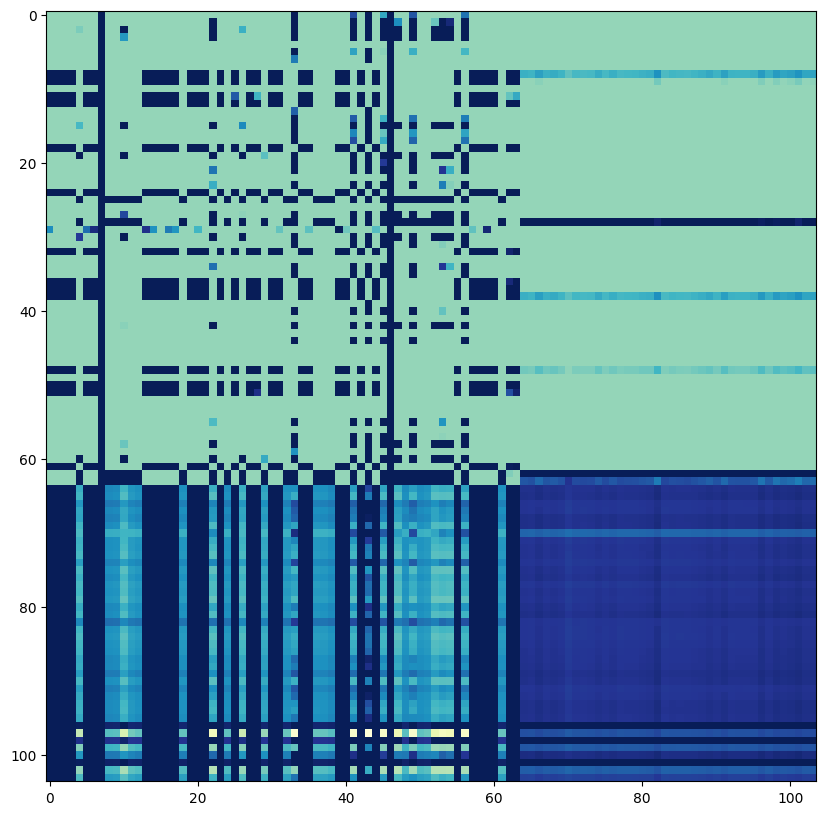

In [44]:
plt.imshow(new_embedding, interpolation="none", cmap=mpl.colormaps["YlGnBu"])
plt.show()

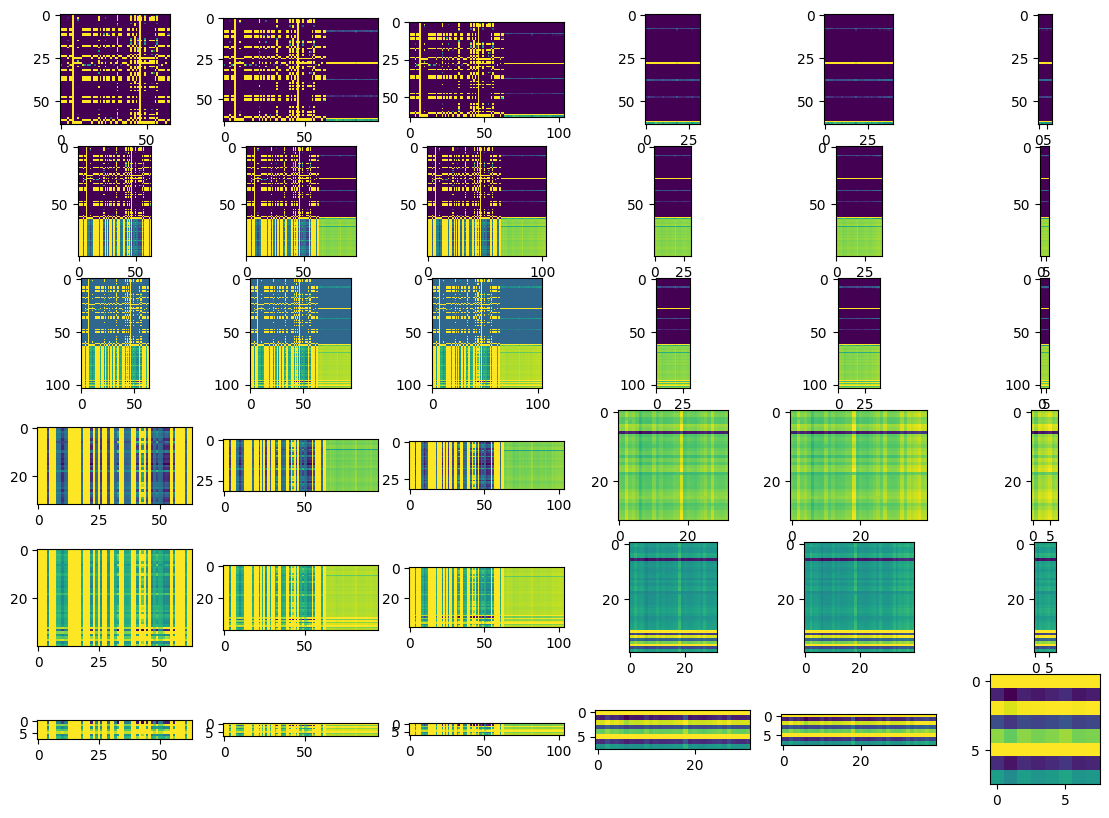

In [45]:
new_embedding = np.zeros((104, 104))
embedding = ((pos_fuse + neg_fuse)/ (pos_total + neg_total))
new_embedding[:64] = np.clip(np.max(np.abs(embedding)[:, :64], axis=0), 5e-5, 1e-4) * 1e4
new_embedding[64:] = np.clip(np.mean(np.abs(embedding[:,64:]), axis=0), 0, 0.003) / 0.003
f, axarr = plt.subplots(6,6)
for i in range(len(combo2d)):
    coordx, coordy = combo2d[i]
    startx, endx = splits[coordx[0]], splits[coordx[1]]
    starty, endy = splits[coordy[0]], splits[coordy[1]]
    axarr[i//6,i%6].imshow(new_embedding[startx: endx, starty:endy], interpolation='none')

plt.show()

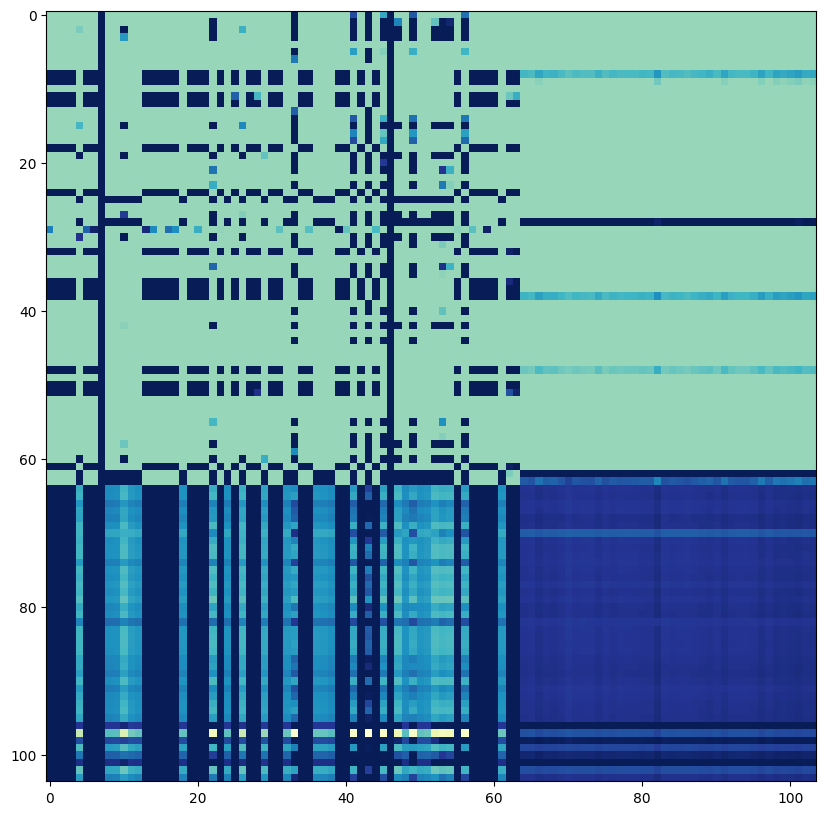

In [46]:
plt.imshow(new_embedding, interpolation="none", cmap=mpl.colormaps["YlGnBu"])
plt.show()